## Brain tumor segmentation model

### Initial set-up for utilizing Colab TPU

In [ ]:
# Connect to TPU
import tensorflow as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print('Running on TPU:', tpu.master())
except ValueError:
    strategy = tf.distribute.get_strategy()  # Use default strategy if TPU not available
    print('Running on default strategy')


Running on TPU: 


### Data Preparation

#### Loading the data from kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saumya12345","key":"b62855291cca7b61b5f1b1672ed1c8bd"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d nikhilroxtomar/brain-tumor-segmentation


Dataset URL: https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation
License(s): unknown
 91% 285M/312M [00:01<00:00, 183MB/s]
100% 312M/312M [00:01<00:00, 184MB/s]


In [ ]:
!ls


brain-tumor-segmentation.zip  sample_data


In [ ]:
import zipfile

with zipfile.ZipFile('brain-tumor-segmentation.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/brain-tumor-segmentation')


In [ ]:
!ls /content/brain-tumor-segmentation


images	masks


#### Converting to numpy array and normalization

In [ ]:
import numpy as np
from PIL import Image
import os

# Define paths to your image and mask directories
image_dir = "/content/brain-tumor-segmentation/images"
mask_dir = "/content/brain-tumor-segmentation/masks"

# List all the PNG files in both directories (assumes the names are the same in both directories)
image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

# Set the target size for resizing
target_size = (256, 256)  # Change this size as needed

# Create empty lists to store the arrays
images = []
masks = []

# Load images and masks into numpy arrays
for img_file, mask_file in zip(image_files, mask_files):
    img_path = os.path.join(image_dir, img_file)
    mask_path = os.path.join(mask_dir, mask_file)

    # Open the image and mask
    img = Image.open(img_path).convert("L")  # Convert to grayscale
    mask = Image.open(mask_path).convert("L")  # Convert to grayscale

    # Resize both image and mask to the target size
    img = img.resize(target_size)
    mask = mask.resize(target_size)

    # Convert to numpy arrays
    img_array = np.array(img)
    mask_array = np.array(mask)

    # Normalize the images and masks
    img_array = img_array / 255.0
    mask_array = mask_array / 255.0

    # Append to lists
    images.append(img_array)
    masks.append(mask_array)

# Convert the lists to numpy arrays
images = np.array(images)
masks = np.array(masks)

# Print the shapes of the arrays
print("Images shape:", images.shape)
print("Masks shape:", masks.shape)


Images shape: (3064, 256, 256)
Masks shape: (3064, 256, 256)


In [ ]:
def check_masks(masks):
  # Checks if all elements in the masks list are either 0 or 1.
  for mask in masks:
    if not np.isin(mask, [0, 1]).all():
      return False
  return True

# Check your masks list
all_0_or_1 = check_masks(masks)

if all_0_or_1:
  print("All mask elements are either 0 or 1")
else:
  print("Some mask elements are not 0 or 1")

Some mask elements are not 0 or 1


In [ ]:
for i in range(len(masks)):
  masks[i] = np.where(masks[i] > 0, 1, 0)  # Set values > 0 to 1, others to 0

# Now re-check if all elements are 0 or 1
all_0_or_1 = check_masks(masks)
print(all_0_or_1)  # Should now print True

True


#### Display a few examples

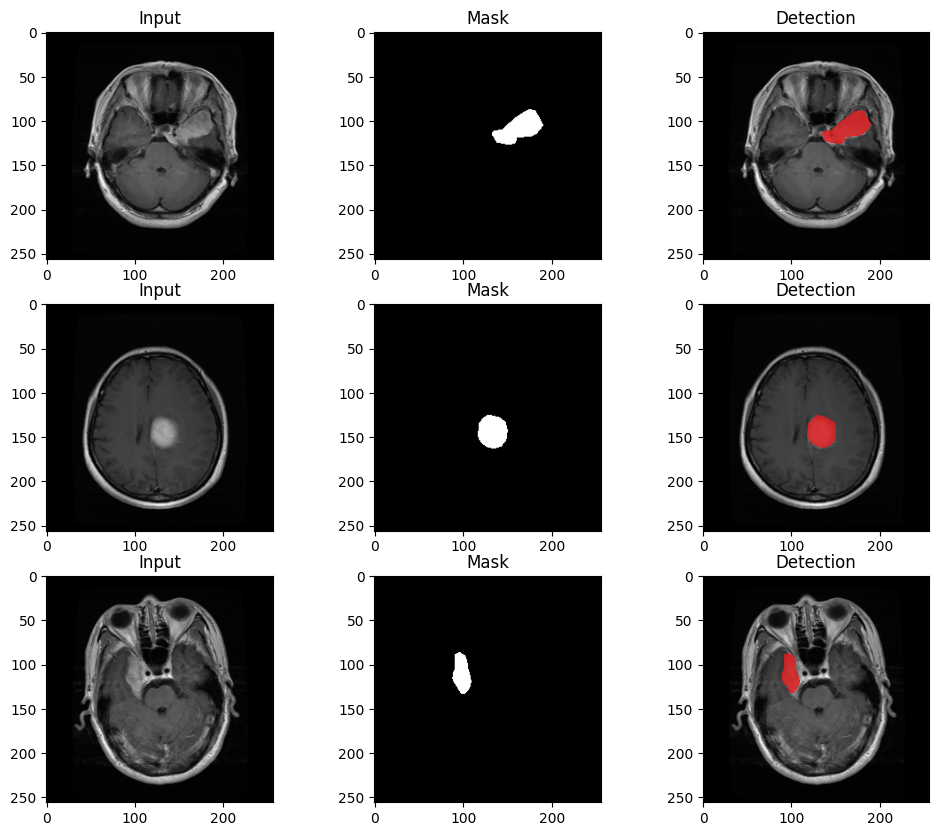

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))

plt.subplot(3,3,1)
plt.title('Input')
plt.imshow(images[0,:], cmap = 'gray')

plt.subplot(3,3,2)
plt.title('Mask')
plt.imshow(masks[0,:], cmap = 'gray')

plt.subplot(3,3,3)
plt.title('Detection')
plt.imshow(images[0,:],cmap='gray')
mask = np.ma.masked_where(masks[0] == False, masks[0])
plt.imshow(mask, alpha=0.8, cmap='Set1')

plt.subplot(3,3,4)
plt.title('Input')
plt.imshow(images[1,:], cmap = 'gray')

plt.subplot(3,3,5)
plt.title('Mask')
plt.imshow(masks[1,:], cmap = 'gray')

plt.subplot(3,3,6)
plt.title('Detection')
plt.imshow(images[1,:],cmap='gray')
mask = np.ma.masked_where(masks[1] == False, masks[1])
plt.imshow(mask, alpha=0.8, cmap='Set1')

plt.subplot(3,3,7)
plt.title('Input')
plt.imshow(images[2,:], cmap = 'gray')

plt.subplot(3,3,8)
plt.title('Mask')
plt.imshow(masks[2,:], cmap = 'gray')

plt.subplot(3,3,9)
plt.title('Detection')
plt.imshow(images[2,:],cmap='gray')
mask = np.ma.masked_where(masks[2] == False, masks[2])
plt.imshow(mask, alpha=0.8, cmap='Set1')

#### Split into train, test and validation sets

In [ ]:
from sklearn.model_selection import train_test_split

# Define the split ratios
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

# Initialize lists to store the split data
train_images, train_masks = [], []
val_images, val_masks = [], []
test_images, test_masks = [], []

# dataset is stored in images, masks arrays


# Split into train, validation, and test for the current batch
X_temp, X_test, mask_temp, mask_test = train_test_split(
        images, masks, test_size=test_ratio, random_state=42
    )
X_train, X_val, mask_train, mask_val = train_test_split(
        X_temp, mask_temp, test_size=val_ratio / (train_ratio + val_ratio), random_state=42
    )





In [ ]:
del images
del masks

In [ ]:
del image_files
del mask_files

In [ ]:
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 1838
Validation set size: 613
Test set size: 613


#### Resizing the data so that channel information is also captured

In [ ]:
# Resizing the data so that channel information is also captured
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

mask_train = mask_train.reshape(mask_train.shape[0], mask_train.shape[1], mask_train.shape[2], 1)
mask_test = mask_test.reshape(mask_test.shape[0], mask_test.shape[1], mask_test.shape[2], 1)

X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
mask_val = mask_val.reshape(mask_val.shape[0], mask_val.shape[1], mask_val.shape[2], 1)

print(X_train.shape)
print(mask_train.shape)
print('\n')
print(X_test.shape)
print(mask_test.shape)
print('\n')
print(X_val.shape)
print(mask_val.shape)

(1838, 256, 256, 1)
(1838, 256, 256, 1)


(613, 256, 256, 1)
(613, 256, 256, 1)


(613, 256, 256, 1)
(613, 256, 256, 1)


In [ ]:
del X_temp
del mask_temp

#### Convert to Tensorflow datasets

In [ ]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa

def augment(image, mask):
    # Randomly decide whether to apply rotation (50% probability)
    decision = tf.random.uniform(())  # Value between 0 and 1
    if decision > 0.5:  # 50% chance to apply rotation
        # Randomly choose +15° or -15° rotation
        if tf.random.uniform(()) > 0.5:
            angle = 15.0 * (tf.constant(3.14159265359) / 180.0)  # +15 degrees in radians
        else:
            angle = -15.0 * (tf.constant(3.14159265359) / 180.0)  # -15 degrees in radians

        # Rotate both the image and mask
        image = tfa.image.rotate(image, angle, interpolation='BILINEAR')
        mask = tfa.image.rotate(mask, angle, interpolation='NEAREST')

        return image, mask

    # If decision <= 0.5, the data is returned as is (no rotation)

    return image, mask


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# Creating a custom Tensorflow dataset
import tensorflow as tf

train_data = tf.data.Dataset.from_tensor_slices((X_train, mask_train))
test_data = tf.data.Dataset.from_tensor_slices((X_test, mask_test))
val_data = tf.data.Dataset.from_tensor_slices((X_val, mask_val))

BATCH_SIZE = 8

train_data = train_data.shuffle(buffer_size=1000)
train_data = train_data.batch(BATCH_SIZE,drop_remainder=True)
train_data = train_data.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)

val_data = val_data.batch(BATCH_SIZE)
val_data = val_data.prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.batch(BATCH_SIZE)
test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE)



In [ ]:
del X_train
del mask_train
del X_test
del mask_test
del X_val
del mask_val

#### Visualize few train_data samples


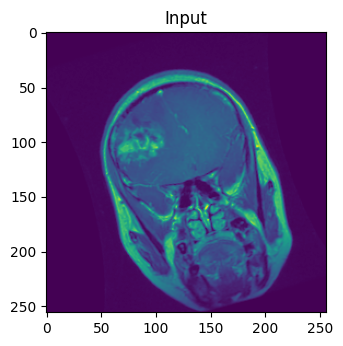

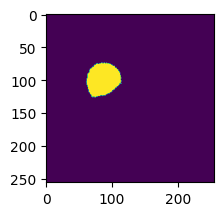

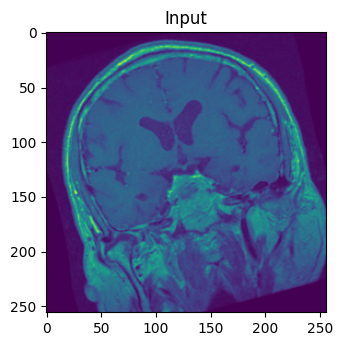

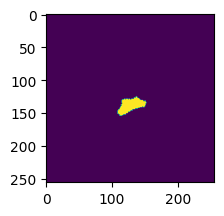

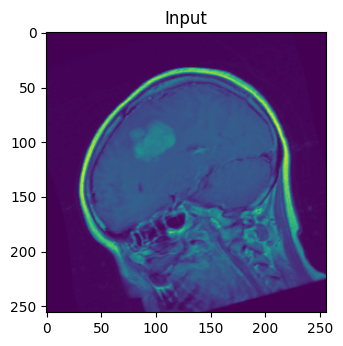

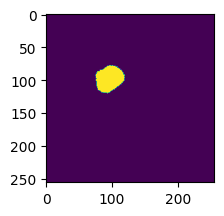

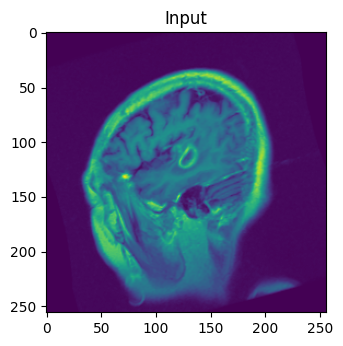

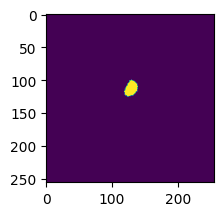

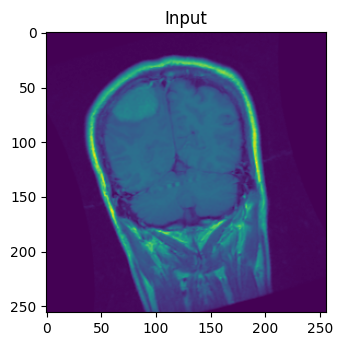

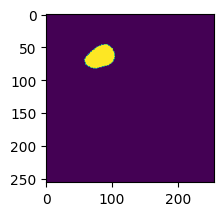

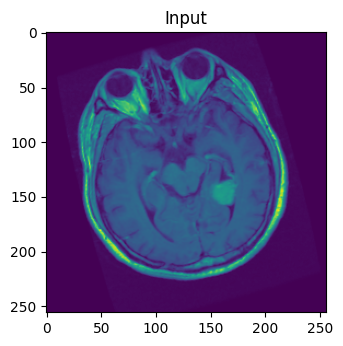

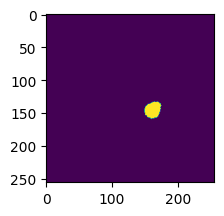

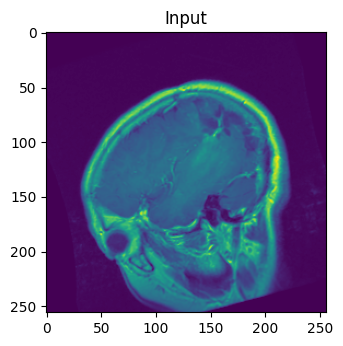

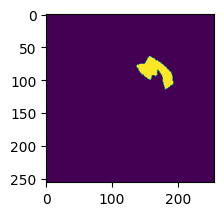

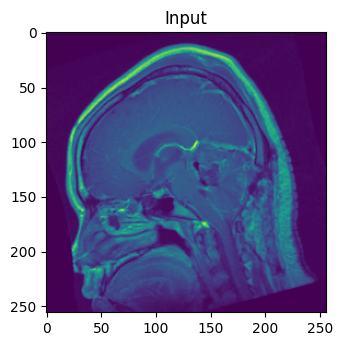

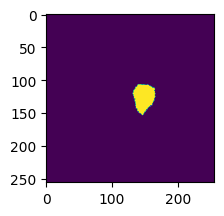

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

for images, masks in train_data.take(1):
  # Iterate through the batch and display each image individually
  for i in range(images.shape[0]):
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 2, 1)
    plt.title('Input')
    plt.imshow(images[i])  # Display the i-th image in the batch
    plt.show()
    # Optionally, display the corresponding mask
    plt.subplot(2, 2, 2)
    plt.imshow(masks[i])
    plt.show()

### Building and Training the model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout

class MonteCarloDropout(Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)  # Always enable dropout

In [ ]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = MonteCarloDropout(0.3)(p)

   return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = MonteCarloDropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x

In [ ]:
def build_unet_model():
 # inputs
   inputs = layers.Input(shape=(256,256,1))

   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
  #  # 4 - downsample
   f4, p4 = downsample_block(p3, 512)

   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)

   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
  #  8 - upsample
   u8 = upsample_block(u7, f2, 128)
  #  # 9 - upsample
   u9 = upsample_block(u8, f1, 64)

   # outputs
   outputs = layers.Conv2D(1, 1, padding="same",  activation="sigmoid")(u9)

   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model

In [ ]:
unet_model = build_unet_model()

In [ ]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
!pip install keras-cv
import keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 30.8 MB/s eta 0:00:00
Using TensorFlow backend


In [ ]:
with strategy.scope():
  # Re-build the model inside the strategy scope
  unet_model = build_unet_model() # Moved inside strategy.scope()

  # Compiling the model within strategy.scope()
  unet_model.compile(loss=keras_cv.losses.FocalLoss(),
                optimizer=tf.keras.optimizers.Adam(1e-4),
                metrics = ['acc'])

  history = unet_model.fit(train_data,epochs = 200, validation_data = val_data)

Epoch 1/200
229/229 [==============================] - 73s 149ms/step - loss: 0.0114 - acc: 0.9757 - val_loss: 0.0069 - val_acc: 0.9813
Epoch 2/200
229/229 [==============================] - 21s 93ms/step - loss: 0.0066 - acc: 0.9818 - val_loss: 0.0063 - val_acc: 0.9813
Epoch 3/200
229/229 [==============================] - 21s 91ms/step - loss: 0.0060 - acc: 0.9817 - val_loss: 0.0057 - val_acc: 0.9813
Epoch 4/200
229/229 [==============================] - 21s 90ms/step - loss: 0.0053 - acc: 0.9825 - val_loss: 0.0049 - val_acc: 0.9830
Epoch 5/200
229/229 [==============================] - 21s 92ms/step - loss: 0.0045 - acc: 0.9847 - val_loss: 0.0045 - val_acc: 0.9851
Epoch 6/200
229/229 [==============================] - 21s 94ms/step - loss: 0.0040 - acc: 0.9857 - val_loss: 0.0043 - val_acc: 0.9864
Epoch 7/200
229/229 [==============================] - 21s 91ms/step - loss: 0.0035 - acc: 0.9870 - val_loss: 0.0037 - val_acc: 0.9843
Epoch 8/200
229/229 [==============================] -

In [ ]:
# Defining a function to extract history from the model and plot the metrics as graphs

def show_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

### Evaluation of model performance

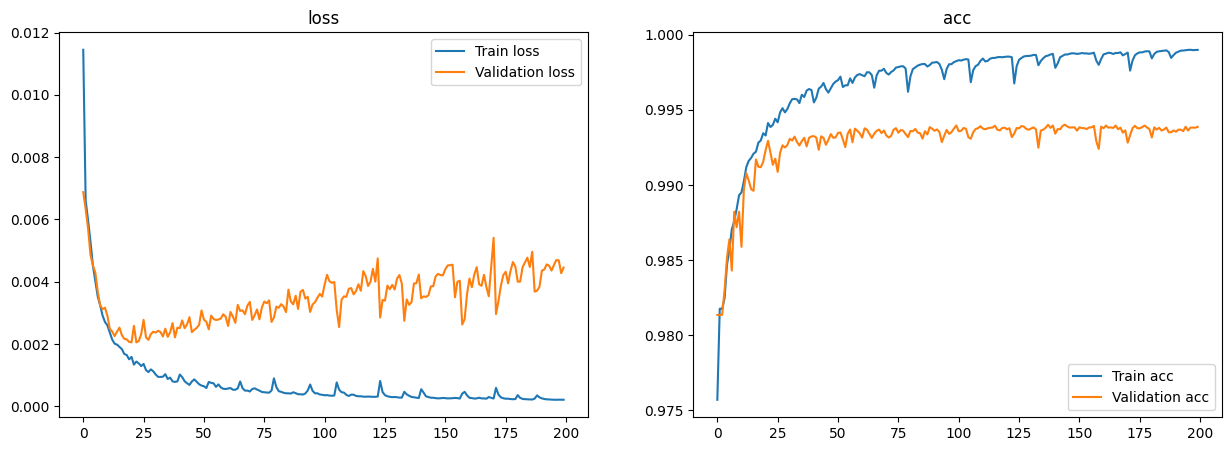

In [ ]:
# Plotting the graphs of variation of training metrics over epochs

show_history(history)

#### Evaluating model performance on test dataset

In [ ]:
# Initialize lists to store images and ground truth masks
all_images = []
all_masks = []

# Iterate through the dataset
for images, masks in test_data:
    all_images.append(images.numpy())  # Convert images to NumPy
    all_masks.append(masks.numpy())   # Convert masks to NumPy

# Flatten the lists to get all images and masks
all_images = np.concatenate(all_images, axis=0)
all_masks = np.concatenate(all_masks, axis=0)

print(f'Total Images: {all_images.shape}')
print(f'Total Masks: {all_masks.shape}')

Total Images: (613, 256, 256, 1)
Total Masks: (613, 256, 256, 1)


##### Model accuracy and loss over test dataset

In [ ]:
# Evaluate the model on the test dataset and print out the accuracy and loss
test_loss, test_accuracy = unet_model.evaluate(test_data)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

77/77 [==============================] - 4s 40ms/step - loss: 0.0047 - acc: 0.9940
Test Loss: 0.0047
Test Accuracy: 0.9940


##### Obtaining mean IoU, mean dice coefficient, precision and recall over test dataset

In [ ]:


# IoU Metric Function
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)  # Ensure the ground truth is float32
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Apply threshold to predictions
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

# Compute IoU for the test dataset
iou_scores = []

for images, masks in test_data:
    predictions = unet_model.predict(images)  # Get model predictions
    iou = iou_metric(masks, predictions)  # Calculate IoU
    iou_scores.append(iou.numpy())  # Convert to NumPy and store

# Calculate mean IoU across the test dataset
mean_iou = sum(iou_scores) / len(iou_scores)
print(f'Mean IoU: {mean_iou:.4f}')


1/1 [==============================] - 0s 427ms/step
Mean IoU: 0.7085


In [ ]:
# Get predictions for the entire dataset
predictions = unet_model.predict(all_images)
predictions = (predictions > 0.5).astype(np.float32)  # Threshold predictions

# Metric functions
def precision(y_true, y_pred):
    true_positive = np.sum(y_true * y_pred)
    predicted_positive = np.sum(y_pred)
    return true_positive / (predicted_positive + 1e-6)

def recall(y_true, y_pred):
    true_positive = np.sum(y_true * y_pred)
    actual_positive = np.sum(y_true)
    return true_positive / (actual_positive + 1e-6)

# Compute precision and recall
test_precision = precision(all_masks, predictions)
test_recall = recall(all_masks, predictions)

print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')


20/20 [==============================] - 17s 462ms/step
Test Precision: 0.9095
Test Recall: 0.7576


In [ ]:


# Dice coefficient function
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """
    Calculate Dice coefficient for two binary masks.
    Args:
        y_true (numpy array): Ground truth mask.
        y_pred (numpy array): Predicted mask.
        smooth (float): Smoothing factor to prevent division by zero.
    Returns:
        float: Dice coefficient.
    """
    intersection = np.sum(y_true * y_pred)
    sum_masks = np.sum(y_true) + np.sum(y_pred)
    dice = (2. * intersection + smooth) / (sum_masks + smooth)
    return dice

# Get predictions for all test images
predictions = unet_model.predict(all_images)
predictions = (predictions > 0.5).astype(np.float32)  # Apply threshold to get binary masks

# Calculate Dice coefficients for each sample
dice_scores = [dice_coefficient(all_masks[i], predictions[i]) for i in range(len(all_masks))]

# Compute the mean Dice coefficient across the test dataset
mean_dice = np.mean(dice_scores)

print(f'Mean Dice Coefficient: {mean_dice:.4f}')


20/20 [==============================] - 2s 44ms/step
Mean Dice Coefficient: 0.7872


Starting uncertainty analysis...

Analyzing Sample 1


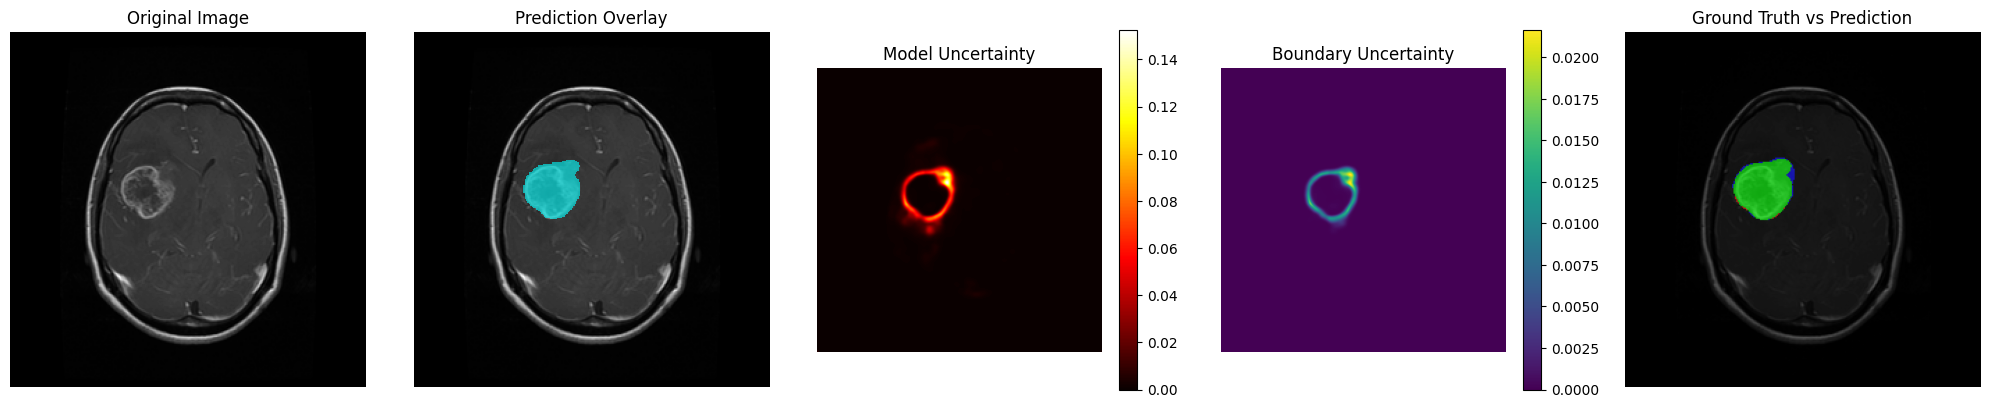


Uncertainty Metrics for Image 1:
Mean Uncertainty: 0.0012
Max Uncertainty: 0.1701
Mean Boundary Uncertainty: 0.0001
Max Boundary Uncertainty: 0.0231

Analyzing Sample 2


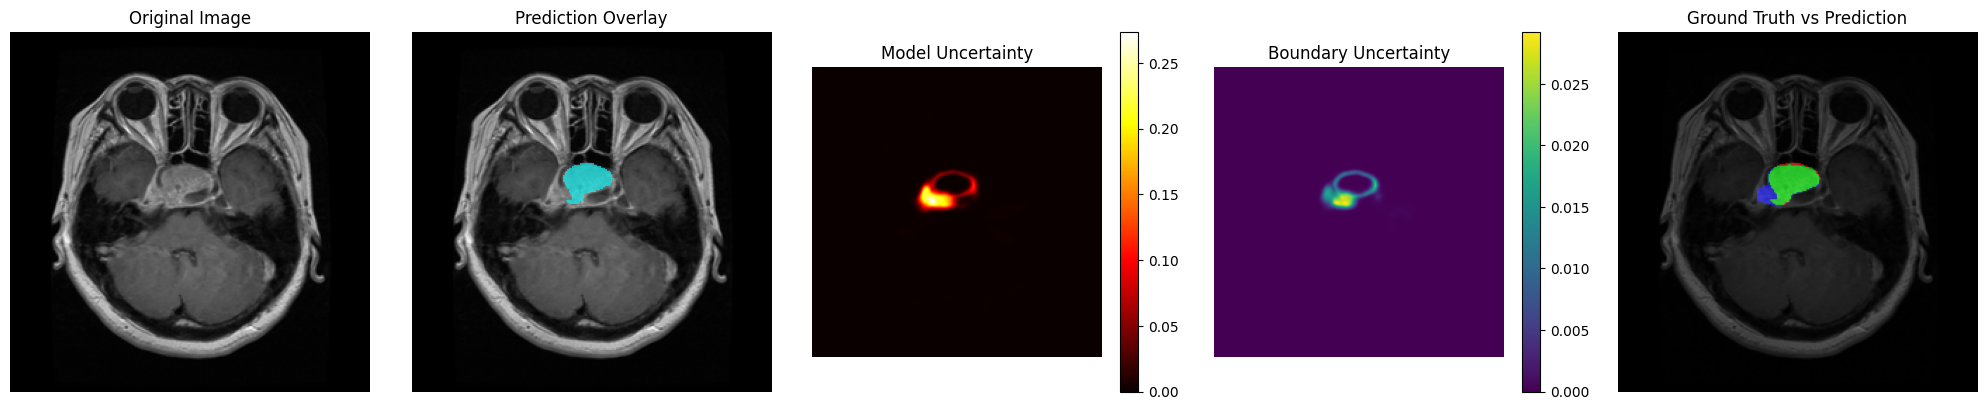


Uncertainty Metrics for Image 2:
Mean Uncertainty: 0.0019
Max Uncertainty: 0.2824
Mean Boundary Uncertainty: 0.0002
Max Boundary Uncertainty: 0.0311

Analyzing Sample 3


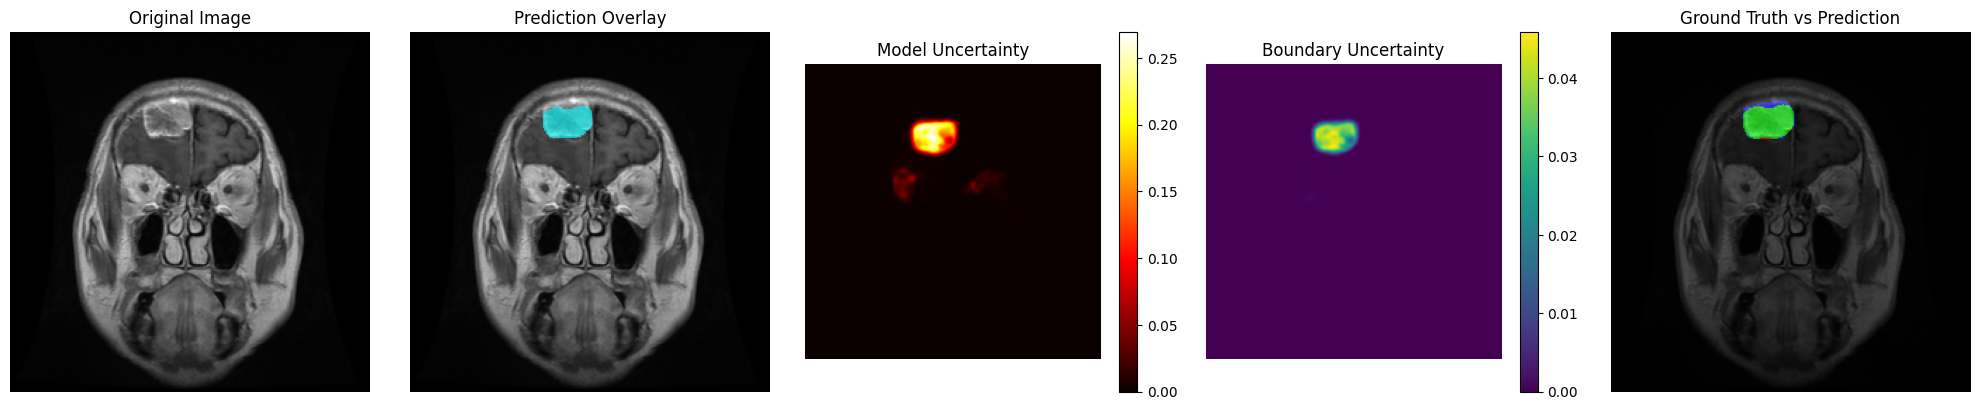


Uncertainty Metrics for Image 3:
Mean Uncertainty: 0.0033
Max Uncertainty: 0.2805
Mean Boundary Uncertainty: 0.0005
Max Boundary Uncertainty: 0.0476

Analyzing Sample 4


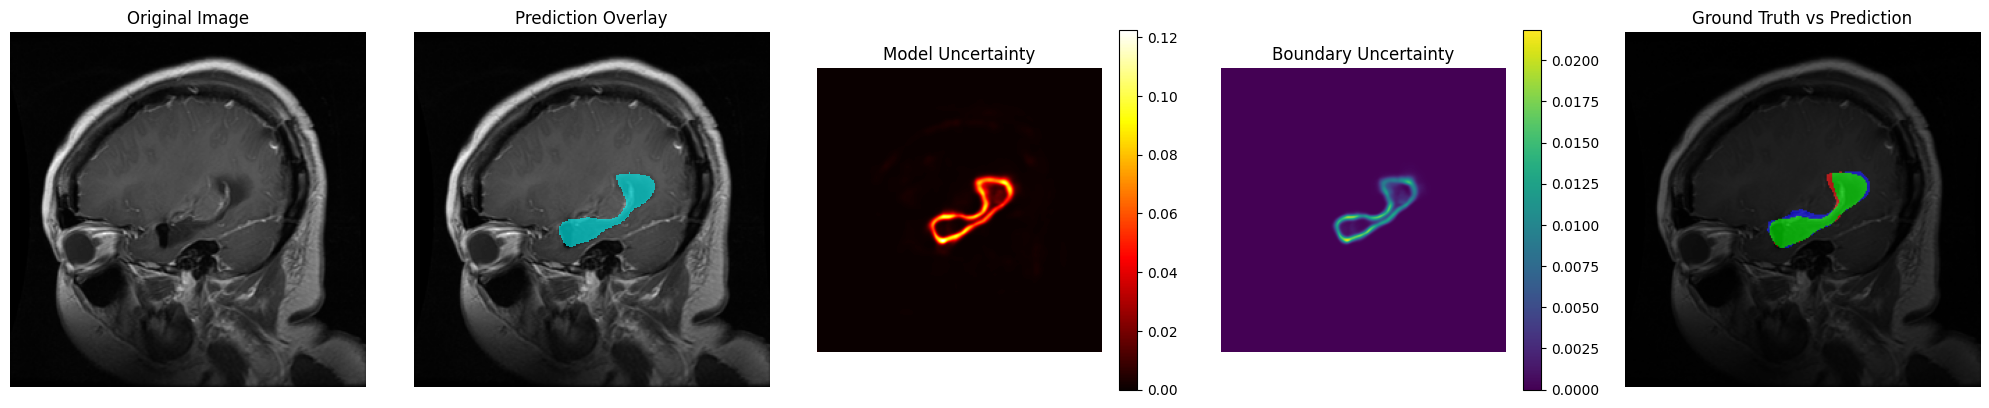


Uncertainty Metrics for Image 4:
Mean Uncertainty: 0.0015
Max Uncertainty: 0.1463
Mean Boundary Uncertainty: 0.0002
Max Boundary Uncertainty: 0.0277

Analyzing Sample 5


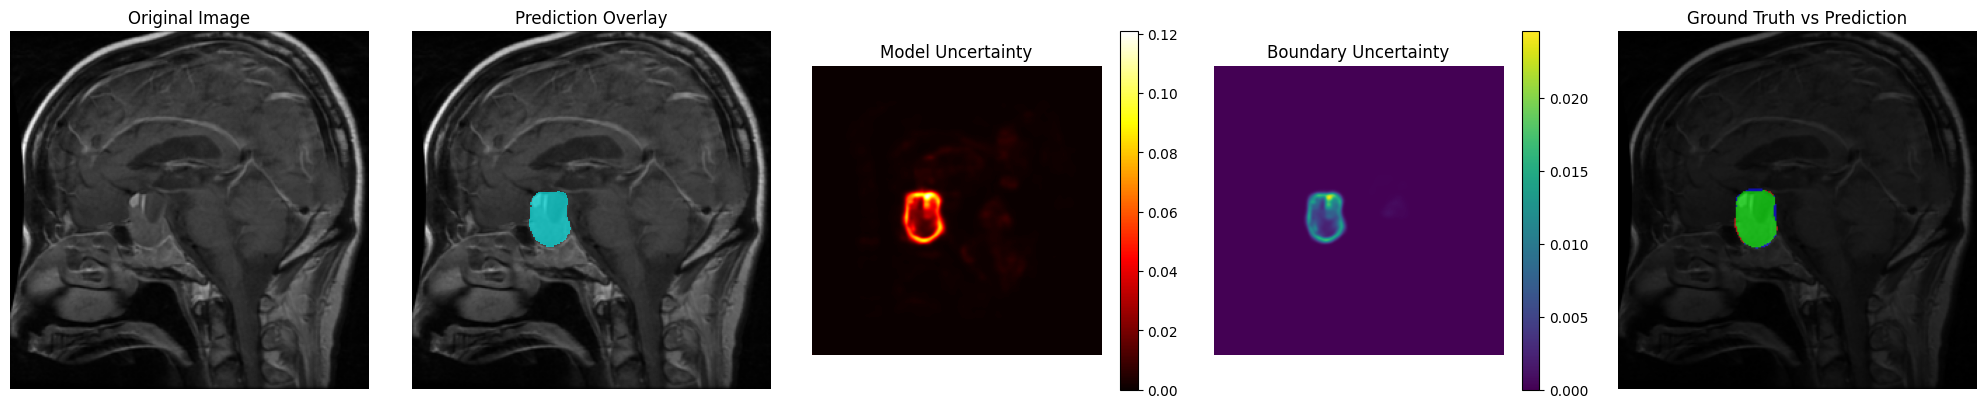


Uncertainty Metrics for Image 5:
Mean Uncertainty: 0.0016
Max Uncertainty: 0.1330
Mean Boundary Uncertainty: 0.0002
Max Boundary Uncertainty: 0.0272
Analysis complete!


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.ndimage import gaussian_filter

def enhanced_mc_dropout_predictions(model, images, num_samples=50):
    """
    Enhanced Monte Carlo Dropout predictions with better uncertainty estimation.
    """
    # Get predictions
    predictions = np.array([model.predict(images, verbose=0) for _ in range(num_samples)])

    # Calculate mean prediction
    mean_pred = np.mean(predictions, axis=0)

    # Calculate uncertainty (variance across predictions)
    uncertainty = np.std(predictions, axis=0)

    # Calculate entropy focusing on boundary regions
    prob_maps = mean_pred
    entropy = -prob_maps * np.log(prob_maps + 1e-7) - (1 - prob_maps) * np.log(1 - prob_maps + 1e-7)

    # Enhance boundary detection
    edges = ndimage.gaussian_gradient_magnitude(mean_pred[..., 0], sigma=1)
    boundary_uncertainty = uncertainty[..., 0,np.newaxis] * edges[..., np.newaxis]

    return mean_pred, uncertainty, entropy, boundary_uncertainty

def visualize_enhanced_uncertainty(image, mean_pred, uncertainty, boundary_uncertainty, ground_truth=None, index=0):
    """
    Enhanced visualization of uncertainty analysis results.
    """
    plt.figure(figsize=(20, 4))

    # Original image
    plt.subplot(151)
    plt.title("Original Image")
    plt.imshow(image[..., 0], cmap='gray')
    plt.axis('off')

    # Mean prediction with tumor overlay
    plt.subplot(152)
    plt.title("Prediction Overlay")
    plt.imshow(image[..., 0], cmap='gray')
    prediction_mask = mean_pred[..., 0] > 0.5
    overlay = np.ma.masked_where(~prediction_mask, prediction_mask)
    plt.imshow(overlay, cmap='cool', alpha=0.6)
    plt.axis('off')

    # Uncertainty map
    plt.subplot(153)
    plt.title("Model Uncertainty")
    uncertainty_plot = plt.imshow(gaussian_filter(uncertainty[..., 0], sigma=1), cmap='hot')
    plt.colorbar(uncertainty_plot)
    plt.axis('off')

    # Boundary uncertainty
    plt.subplot(154)
    plt.title("Boundary Uncertainty")
    boundary_plot = plt.imshow(gaussian_filter(boundary_uncertainty[..., 0], sigma=1), cmap='viridis')
    plt.colorbar(boundary_plot)
    plt.axis('off')

    # Ground truth comparison
    plt.subplot(155)
    if ground_truth is not None:
        plt.title("Ground Truth vs Prediction")
        plt.imshow(image[..., 0], cmap='gray')
        truth_mask = ground_truth[..., 0] > 0.5
        pred_mask = mean_pred[..., 0] > 0.5

        # Green: True Positive, Red: False Positive, Blue: False Negative
        comparison = np.zeros((*truth_mask.shape, 3))
        comparison[truth_mask & pred_mask] = [0, 1, 0]  # True Positive
        comparison[~truth_mask & pred_mask] = [1, 0, 0]  # False Positive
        comparison[truth_mask & ~pred_mask] = [0, 0, 1]  # False Negative

        plt.imshow(comparison, alpha=0.6)
    else:
        plt.title("No Ground Truth Available")
        plt.imshow(image[..., 0], cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Print uncertainty metrics
    print(f"\nUncertainty Metrics for Image {index + 1}:")
    print(f"Mean Uncertainty: {np.mean(uncertainty):.4f}")
    print(f"Max Uncertainty: {np.max(uncertainty):.4f}")
    print(f"Mean Boundary Uncertainty: {np.mean(boundary_uncertainty):.4f}")
    print(f"Max Boundary Uncertainty: {np.max(boundary_uncertainty):.4f}")

def analyze_test_samples(model, test_data, num_samples=3):
    """
    Analyze multiple test samples with enhanced visualization.
    """
    for i, (images, masks) in enumerate(test_data.take(num_samples)):
        print(f"\nAnalyzing Sample {i+1}")

        # Get uncertainty predictions
        mean_pred, uncertainty, entropy, boundary_uncertainty = enhanced_mc_dropout_predictions(
            model, images, num_samples=50
        )

        # Visualize results
        visualize_enhanced_uncertainty(
            images[0].numpy(),
            mean_pred[0],
            uncertainty[0],
            boundary_uncertainty[0],
            masks[0].numpy(),
            index=i
        )


def run_analysis():
    """
    Run the complete analysis pipeline.
    """
    print("Starting uncertainty analysis...")
    analyze_test_samples(unet_model, test_data, num_samples=5)
    print("Analysis complete!")

# Run the analysis
run_analysis()

In [ ]:
!pip install opencv-python
import cv2

Image batch shape: (1, 256, 256, 1)


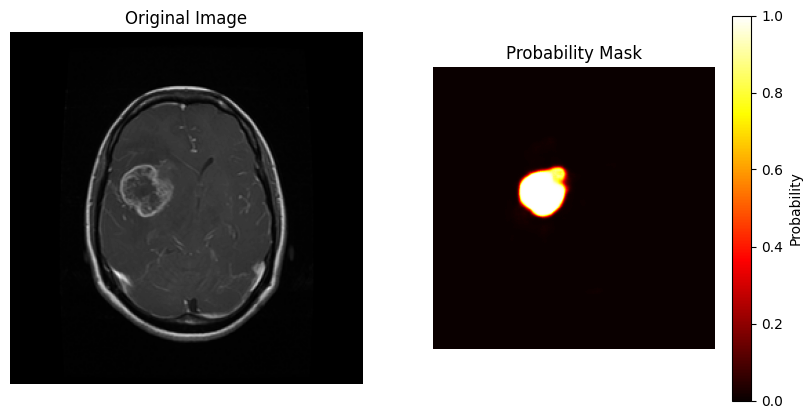

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to preprocess the input image
def preprocess_image(image_array, target_size=(256, 256)):
    """
    Preprocess an MRI image (as a NumPy array) to feed into the model.

    Args:
        image_array (numpy array): MRI image as a NumPy array.
        target_size (tuple): Desired size of the image (height, width).

    Returns:
        preprocessed_image (numpy array): Preprocessed image ready for model input.
    """
    # Resize the image to match the model's input size
    image_resized = cv2.resize(image_array, target_size)

    # # Normalize pixel values to the range [0, 1]
    # image_normalized = image_resized / 255.0
    image_normalized = image_resized

    # Add batch dimension (model expects input shape [batch_size, height, width, channels])
    image_normalized = np.expand_dims(image_normalized, axis=(0, -1))  # Add batch and channel dimensions

    return image_normalized

# Function to generate a probability mask
def get_probability_mask(model, image_array):
    """
    Generate a probabilistic mask for the given image using the trained model.

    Args:
        model (tf.keras.Model): The trained segmentation model.
        image_array (numpy array): MRI image as a NumPy array.

    Returns:
        prob_mask (numpy array): Model's probabilistic output (values between 0 and 1).
    """
    # Preprocess the image
    preprocessed_image = preprocess_image(image_array)

    # Predict the probability mask
    prob_mask = model.predict(preprocessed_image, verbose=0)

    # Remove batch and channel dimensions
    prob_mask = np.squeeze(prob_mask)

    return prob_mask



model = unet_model
image = all_images[0]


if len(image.shape) == 2:  # Grayscale image
    image = np.expand_dims(image, axis=-1)  # Add channel dimension, shape: (256, 256, 1)

# Add batch dimension, shape: (1, 256, 256, channels)
image_batch = np.expand_dims(image, axis=0)


print("Image batch shape:", image_batch.shape)  # Should be (1, 256, 256, channels)


# Generate the probability mask
probability_mask = get_probability_mask(model, image)

# Plot the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Probability Mask")
plt.imshow(probability_mask, cmap='hot', vmin=0, vmax=1)
plt.colorbar(label="Probability")
plt.axis('off')



plt.show()

# Save the probability mask
np.save("probability_mask.npy", probability_mask)

In [ ]:


def calculate_boundary_metrics(prediction, uncertainty):
    """
    Calculate detailed boundary uncertainty metrics.
    """
    # Generate boundary mask
    boundary_kernel = np.array([[-1, -1, -1],
                              [-1,  8, -1],
                              [-1, -1, -1]])
    boundary_mask = ndimage.convolve(prediction[..., 0], boundary_kernel) > 0

    # Calculate boundary uncertainty statistics
    boundary_uncertainties = uncertainty[..., 0][boundary_mask]

    metrics = {
        'mean_boundary_uncertainty': np.mean(boundary_uncertainties),
        'std_boundary_uncertainty': np.std(boundary_uncertainties),
        'max_boundary_uncertainty': np.max(boundary_uncertainties),
        'boundary_length': np.sum(boundary_mask)
    }

    return metrics, boundary_mask

def plot_uncertainty_distributions(uncertainty, boundary_uncertainty):
    """
    Plot distributions of different uncertainty measures.
    """
    plt.figure(figsize=(12, 4))

    # Overall uncertainty distribution
    plt.subplot(121)
    plt.title("Overall Uncertainty Distribution")
    plt.hist(uncertainty[..., 0].flatten(), bins=50, density=True, alpha=0.7)
    plt.xlabel("Uncertainty Value")
    plt.ylabel("Density")

    # Boundary uncertainty distribution
    plt.subplot(122)
    plt.title("Boundary Uncertainty Distribution")
    plt.hist(boundary_uncertainty[..., 0].flatten(), bins=50, density=True, alpha=0.7)
    plt.xlabel("Boundary Uncertainty Value")
    plt.ylabel("Density")

    plt.tight_layout()
    plt.show()


def visualize_enhanced_uncertainty(image, mean_pred, uncertainty, boundary_uncertainty, ground_truth=None, index=0):
    """
    Enhanced visualization with additional uncertainty measures.
    """
    plt.figure(figsize=(20, 8))

    # Original layout
    plt.subplot(231)
    plt.title("Original Image")
    plt.imshow(image[..., 0], cmap='gray')
    plt.axis('off')

    plt.subplot(232)
    plt.title("Prediction Overlay")
    plt.imshow(image[..., 0], cmap='gray')
    prediction_mask = mean_pred[..., 0] > 0.5
    overlay = np.ma.masked_where(~prediction_mask, prediction_mask)
    plt.imshow(overlay, cmap='cool', alpha=0.6)
    plt.axis('off')

    plt.subplot(233)
    plt.title("Model Uncertainty")
    uncertainty_plot = plt.imshow(gaussian_filter(uncertainty[..., 0], sigma=1), cmap='hot')
    plt.colorbar(uncertainty_plot)
    plt.axis('off')

    plt.subplot(234)
    plt.title("Boundary Uncertainty")
    boundary_plot = plt.imshow(gaussian_filter(boundary_uncertainty[..., 0], sigma=1), cmap='viridis')
    plt.colorbar(boundary_plot)
    plt.axis('off')

    # Boundary probability map
    plt.subplot(235)
    plt.title("Boundary Probability")
    _, boundary_mask = calculate_boundary_metrics(mean_pred, uncertainty)
    plt.imshow(gaussian_filter(boundary_mask.astype(float), sigma=1), cmap='RdYlBu')
    plt.colorbar()
    plt.axis('off')

    # Ground truth comparison
    plt.subplot(236)
    if ground_truth is not None:
        plt.title("Ground Truth vs Prediction")
        plt.imshow(image[..., 0], cmap='gray')
        truth_mask = ground_truth[..., 0] > 0.5
        pred_mask = mean_pred[..., 0] > 0.5

        comparison = np.zeros((*truth_mask.shape, 3))
        comparison[truth_mask & pred_mask] = [0, 1, 0]  # True Positive
        comparison[~truth_mask & pred_mask] = [1, 0, 0]  # False Positive
        comparison[truth_mask & ~pred_mask] = [0, 0, 1]  # False Negative

        plt.imshow(comparison, alpha=0.6)
    else:
        plt.title("No Ground Truth Available")
        plt.imshow(image[..., 0], cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Plot uncertainty distributions
    plot_uncertainty_distributions(uncertainty, boundary_uncertainty)

    # Print comprehensive metrics
    print(f"\nUncertainty Metrics for Image {index+1}:")
    boundary_metrics, _ = calculate_boundary_metrics(mean_pred, uncertainty)
    print(f"Mean Uncertainty: {np.mean(uncertainty):.4f}")
    print(f"Max Uncertainty: {np.max(uncertainty):.4f}")
    print("\nBoundary Metrics:")
    for key, value in boundary_metrics.items():
        print(f"{key}: {value:.4f}")


def analyze_test_samples(model, test_data, num_samples=3):
    """
    Analyze multiple test samples with enhanced visualization.
    """
    all_uncertainties = []
    all_boundary_metrics = []

    for i, (images, masks) in enumerate(test_data.take(num_samples)):
        print(f"\nAnalyzing Sample {i+1}")


        mean_pred, uncertainty, entropy, boundary_uncertainty = enhanced_mc_dropout_predictions(
            model, images, num_samples=50
        )

        # Store metrics for later analysis
        all_uncertainties.append({
            'total': uncertainty[0],
            'boundary': boundary_uncertainty[0]
        })

        # Visualize results with enhanced visualization
        visualize_enhanced_uncertainty(
            images[0].numpy(),
            mean_pred[0],
            uncertainty[0],
            boundary_uncertainty[0],
            masks[0].numpy(),
            index=i
        )

        # Calculate and store boundary metrics
        metrics, _ = calculate_boundary_metrics(mean_pred[0], uncertainty[0])
        all_boundary_metrics.append(metrics)

    # Summarize analysis across all samples
    print("\nSummary Statistics Across All Samples:")
    print("Mean Total Uncertainty:", np.mean([np.mean(u['total']) for u in all_uncertainties]))
    print("\nMean Boundary Metrics:")
    for key in all_boundary_metrics[0].keys():
        mean_value = np.mean([metrics[key] for metrics in all_boundary_metrics])
        print(f"{key}: {mean_value:.4f}")


def run_analysis():
    """
    Run the complete analysis pipeline.
    """
    print("Starting uncertainty analysis...")
    analyze_test_samples(unet_model, test_data, num_samples=5)
    print("Analysis complete!")

Starting uncertainty analysis...

Analyzing Sample 1


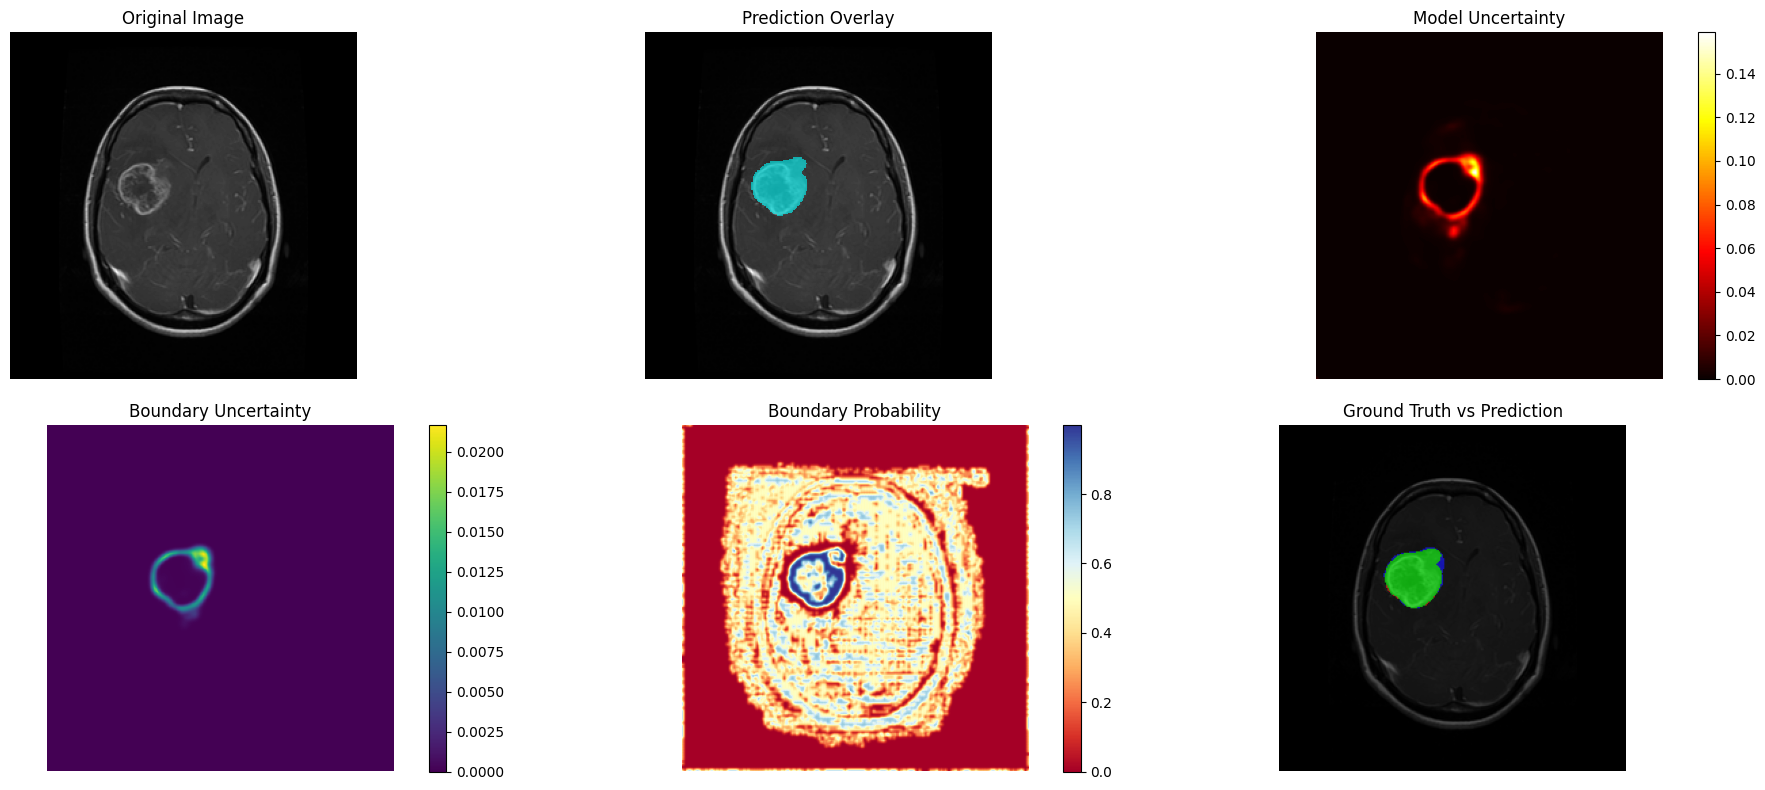

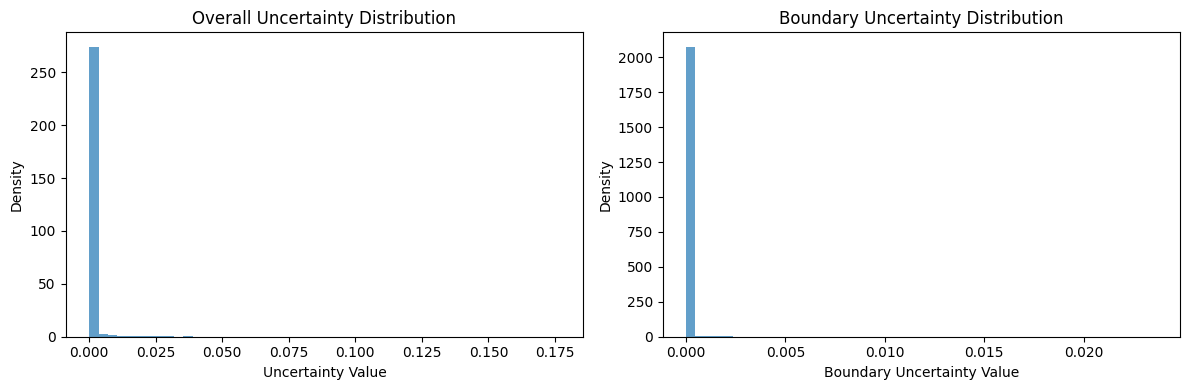


Uncertainty Metrics for Image 1:
Mean Uncertainty: 0.0011
Max Uncertainty: 0.1768

Boundary Metrics:
mean_boundary_uncertainty: 0.0020
std_boundary_uncertainty: 0.0102
max_boundary_uncertainty: 0.1467
boundary_length: 15460.0000

Analyzing Sample 2


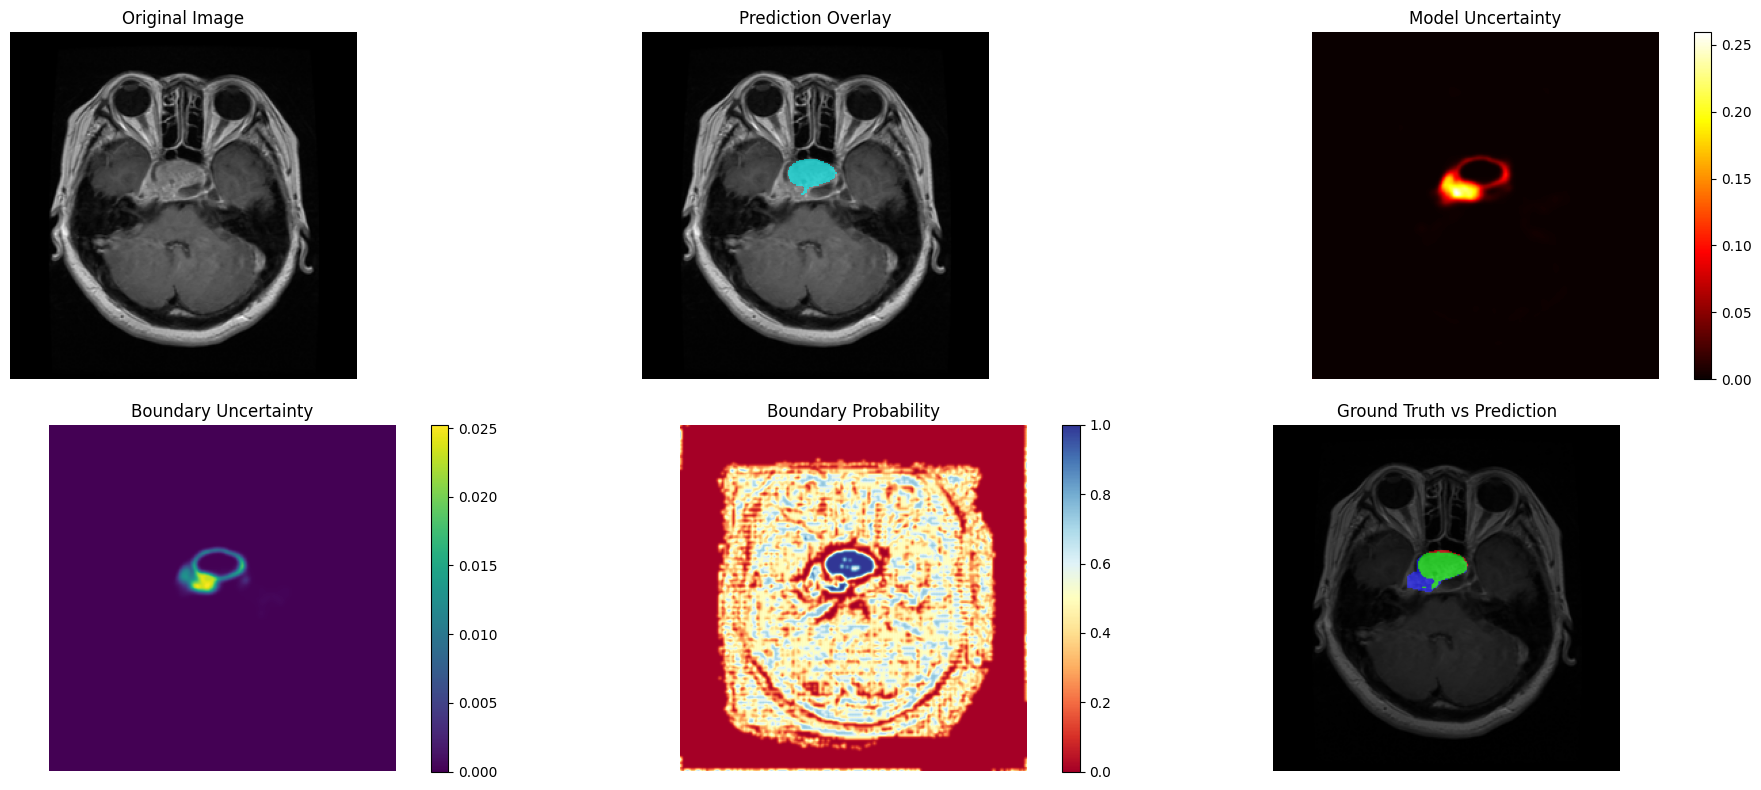

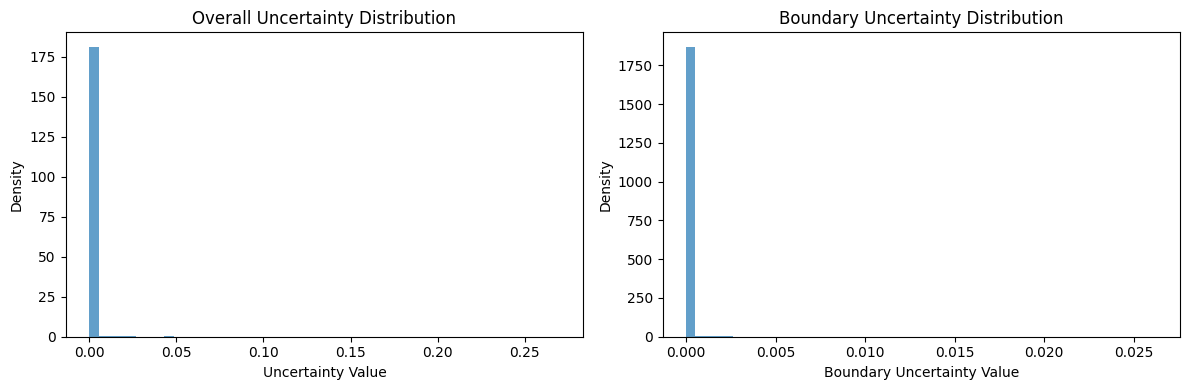


Uncertainty Metrics for Image 2:
Mean Uncertainty: 0.0018
Max Uncertainty: 0.2699

Boundary Metrics:
mean_boundary_uncertainty: 0.0033
std_boundary_uncertainty: 0.0209
max_boundary_uncertainty: 0.2699
boundary_length: 16953.0000

Analyzing Sample 3


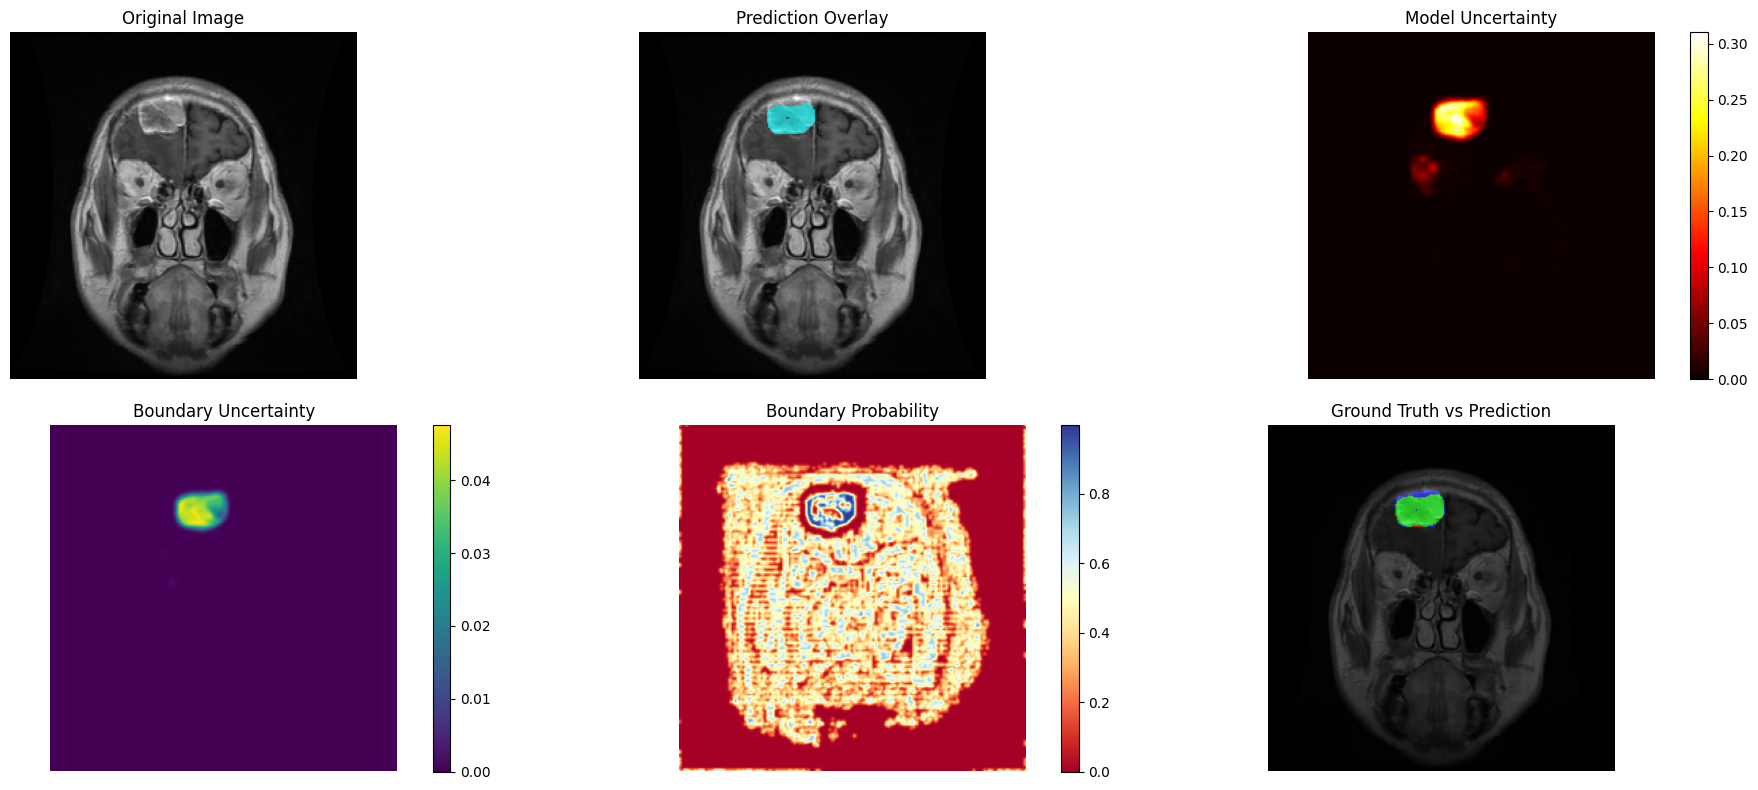

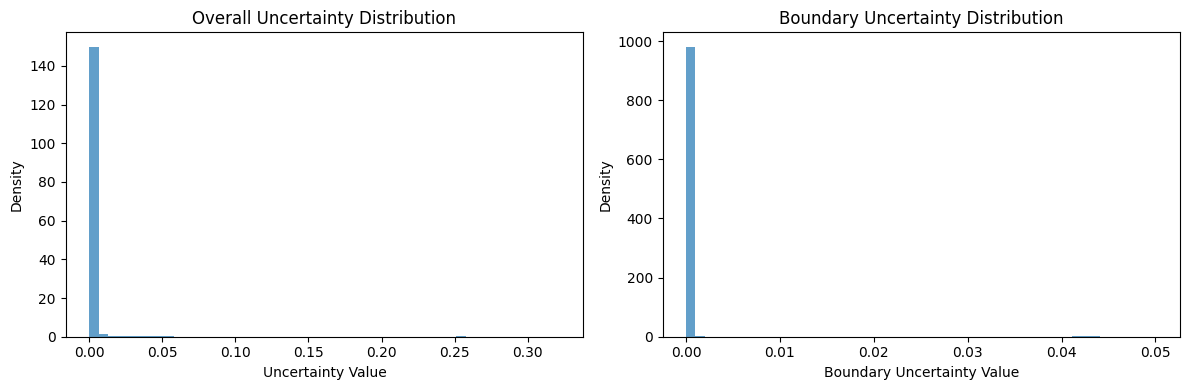


Uncertainty Metrics for Image 3:
Mean Uncertainty: 0.0036
Max Uncertainty: 0.3218

Boundary Metrics:
mean_boundary_uncertainty: 0.0096
std_boundary_uncertainty: 0.0419
max_boundary_uncertainty: 0.3129
boundary_length: 13998.0000

Analyzing Sample 4


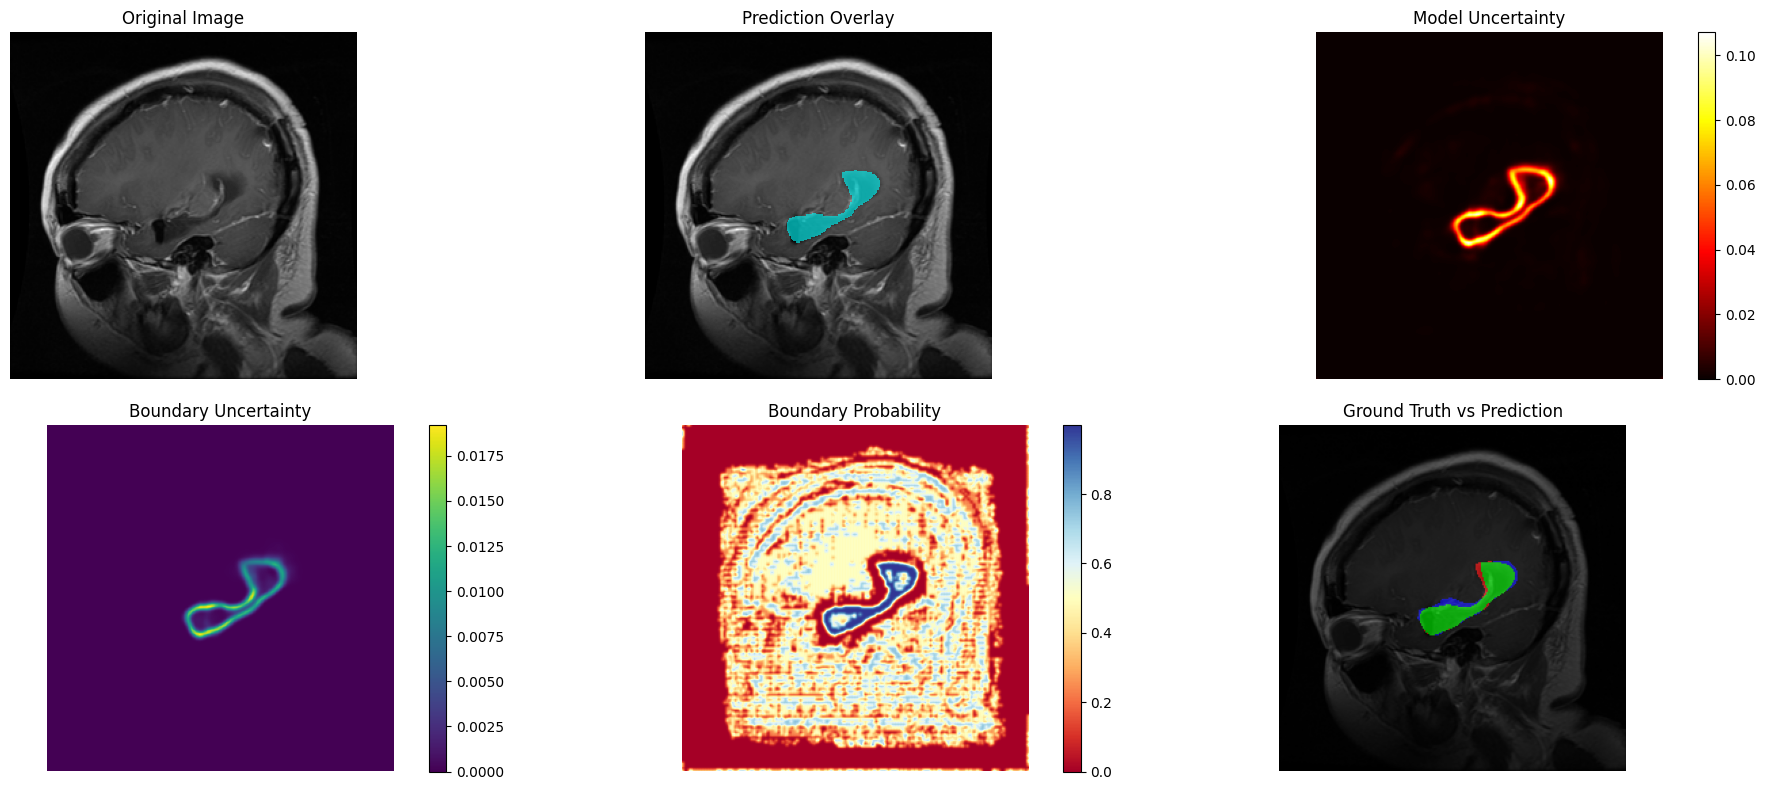

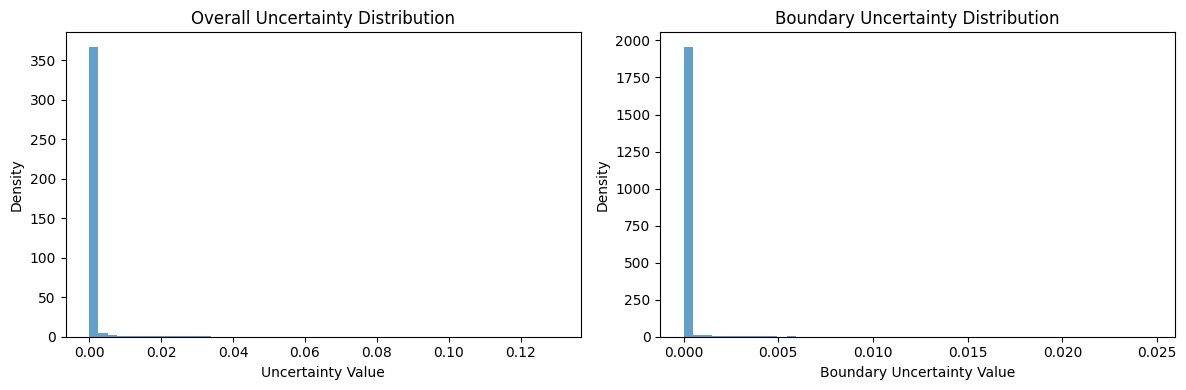


Uncertainty Metrics for Image 4:
Mean Uncertainty: 0.0015
Max Uncertainty: 0.1302

Boundary Metrics:
mean_boundary_uncertainty: 0.0026
std_boundary_uncertainty: 0.0116
max_boundary_uncertainty: 0.1302
boundary_length: 17964.0000

Analyzing Sample 5


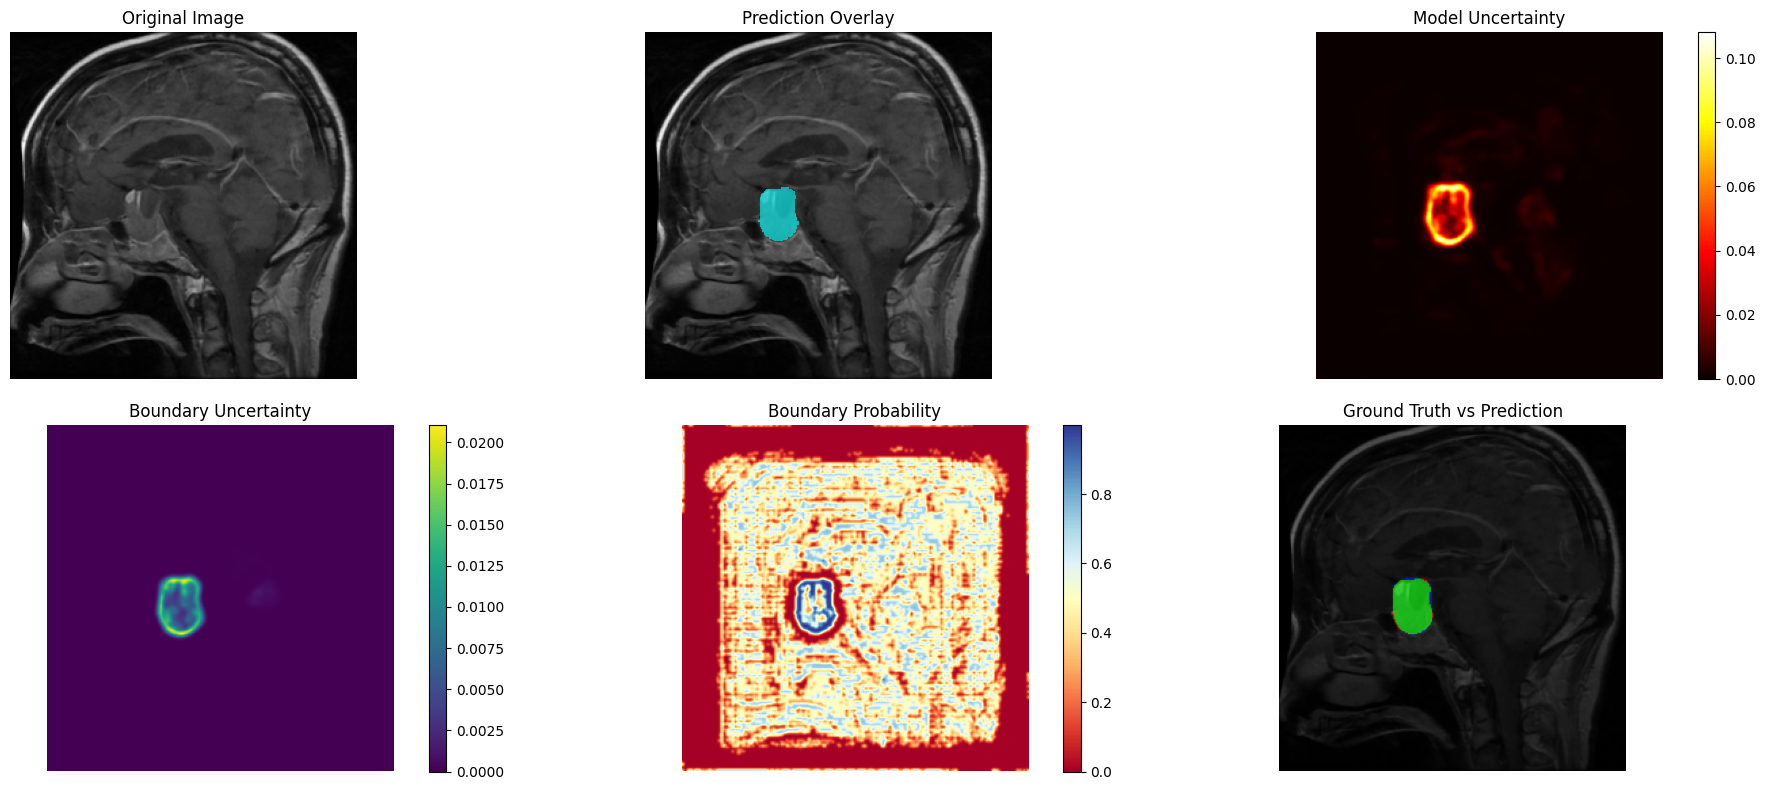

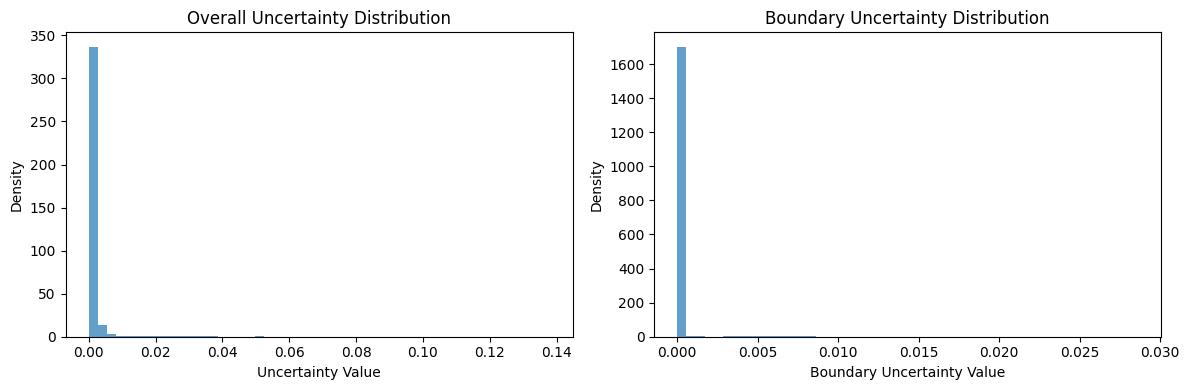


Uncertainty Metrics for Image 5:
Mean Uncertainty: 0.0016
Max Uncertainty: 0.1380

Boundary Metrics:
mean_boundary_uncertainty: 0.0028
std_boundary_uncertainty: 0.0105
max_boundary_uncertainty: 0.1380
boundary_length: 19957.0000

Summary Statistics Across All Samples:
Mean Total Uncertainty: 0.0019452041

Mean Boundary Metrics:
mean_boundary_uncertainty: 0.0040
std_boundary_uncertainty: 0.0190
max_boundary_uncertainty: 0.1995
boundary_length: 16866.4000
Analysis complete!


In [ ]:
run_analysis()